In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)


In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 5,  7,  4,  0,  1,  2, 10,  9,  6]), tensor([3, 8]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [7]:
import torch.nn as nn  # PyTorchのニューラルネットワークモジュールをインポート

# 単純な線形モデル（y = wx + b）を定義
# 入力次元1、出力次元1（例：温度変換などの単回帰に使用可能）
linear_model = nn.Linear(1, 1)

# 検証用入力テンソル t_un_val を線形モデルに通す（予測を行う）
linear_model(t_un_val)

tensor([[3.1678],
        [1.6025]], grad_fn=<AddmmBackward0>)

In [8]:
linear_model.weight

Parameter containing:
tensor([[0.4673]], requires_grad=True)

In [9]:
linear_model.bias

Parameter containing:
tensor([-0.6591], requires_grad=True)

In [10]:
x = torch.ones(1)
linear_model(x)

tensor([-0.1918], grad_fn=<ViewBackward0>)

In [11]:
# すべての要素が1の入力テンソルを作成（バッチサイズ10、特徴量1）
x = torch.ones(10, 1)

# 線形モデルに入力テンソルを通して出力を得る（推論）
linear_model(x)

tensor([[-0.1918],
        [-0.1918],
        [-0.1918],
        [-0.1918],
        [-0.1918],
        [-0.1918],
        [-0.1918],
        [-0.1918],
        [-0.1918],
        [-0.1918]], grad_fn=<AddmmBackward0>)

In [12]:
linear_model = nn.Linear(1, 1)  # 入力1次元、出力1次元の線形回帰モデルを定義

optimizer = optim.SGD(  # Stochastic Gradient Descent (確率的勾配降下法) を使用して
    linear_model.parameters(),  # モデルの学習パラメータ（重み・バイアス）を最適化対象とする
    lr=1e-2,  # 学習率（Learning Rate）を0.01に設定
)

In [13]:
linear_model.parameters()

<generator object Module.parameters at 0x11dee1460>

In [14]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.4343]], requires_grad=True),
 Parameter containing:
 tensor([0.2826], requires_grad=True)]

In [15]:
def training_loop(
    n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val
):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)  # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)  # <1>
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()  # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(
                f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                f" Validation loss {loss_val.item():.4f}"
            )

In [16]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()


linear_model = nn.Linear(1, 1)  # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=loss_fn,
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val,
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 202.7425, Validation loss 559.3295
Epoch 1000, Training loss 3.4553, Validation loss 12.8906
Epoch 2000, Training loss 2.4836, Validation loss 7.1978
Epoch 3000, Training loss 2.4375, Validation loss 6.2814

Parameter containing:
tensor([[5.0872]], requires_grad=True)
Parameter containing:
tensor([-15.7742], requires_grad=True)


In [17]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),  # <1>
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val,
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 53.5019, Validation loss 196.4221
Epoch 1000, Training loss 3.5119, Validation loss 13.1341
Epoch 2000, Training loss 2.4863, Validation loss 7.2320
Epoch 3000, Training loss 2.4376, Validation loss 6.2880

Parameter containing:
tensor([[5.0864]], requires_grad=True)
Parameter containing:
tensor([-15.7695], requires_grad=True)


In [18]:
# nn.Sequentialを用いて順伝播型のニューラルネットワークを定義
seq_model = nn.Sequential(
    nn.Linear(1, 13),  # 入力1次元 → 中間層13ユニットへの線形変換
    nn.Tanh(),  # 活性化関数：双曲線正接関数（Tanh）で非線形性を導入
    nn.Linear(13, 1),  # 中間層13ユニット → 出力1次元への線形変換
)

seq_model  # モデルの構造を出力

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [19]:
# モデル内のすべてのパラメータ（重み・バイアス）の形状をリストで取得
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [20]:
# モデル内のすべてのパラメータ名とその形状を出力する
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [21]:
from collections import OrderedDict

# OrderedDict を使って名前付きレイヤーを定義することで、
# 各層にアクセスしやすくした nn.Sequential モデルを構築
seq_model = nn.Sequential(
    OrderedDict(
        [
            ("hidden_linear", nn.Linear(1, 8)),  # 入力層 → 隠れ層（線形変換）
            ("hidden_activation", nn.Tanh()),  # 非線形活性化関数（双曲線正接）
            ("output_linear", nn.Linear(8, 1)),  # 隠れ層 → 出力層（線形変換）
        ]
    )
)

seq_model  # モデル構造を表示

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [22]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [23]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0855], requires_grad=True)

In [24]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)  # <1>

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val,
)

print("output", seq_model(t_un_val))
print("answer", t_c_val)
print("hidden", seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 142.4114, Validation loss 418.7050
Epoch 1000, Training loss 4.8089, Validation loss 60.6410
Epoch 2000, Training loss 2.7635, Validation loss 30.4321
Epoch 3000, Training loss 2.3797, Validation loss 20.6842
Epoch 4000, Training loss 2.2048, Validation loss 15.5254
Epoch 5000, Training loss 2.1084, Validation loss 12.3457
output tensor([[23.4125],
        [ 7.9081]], grad_fn=<AddmmBackward0>)
answer tensor([[28.],
        [ 6.]])
hidden tensor([[-0.0054],
        [ 0.0039],
        [-0.0257],
        [-0.0013],
        [-0.0049],
        [ 0.0033],
        [-0.0112],
        [ 0.0256]])


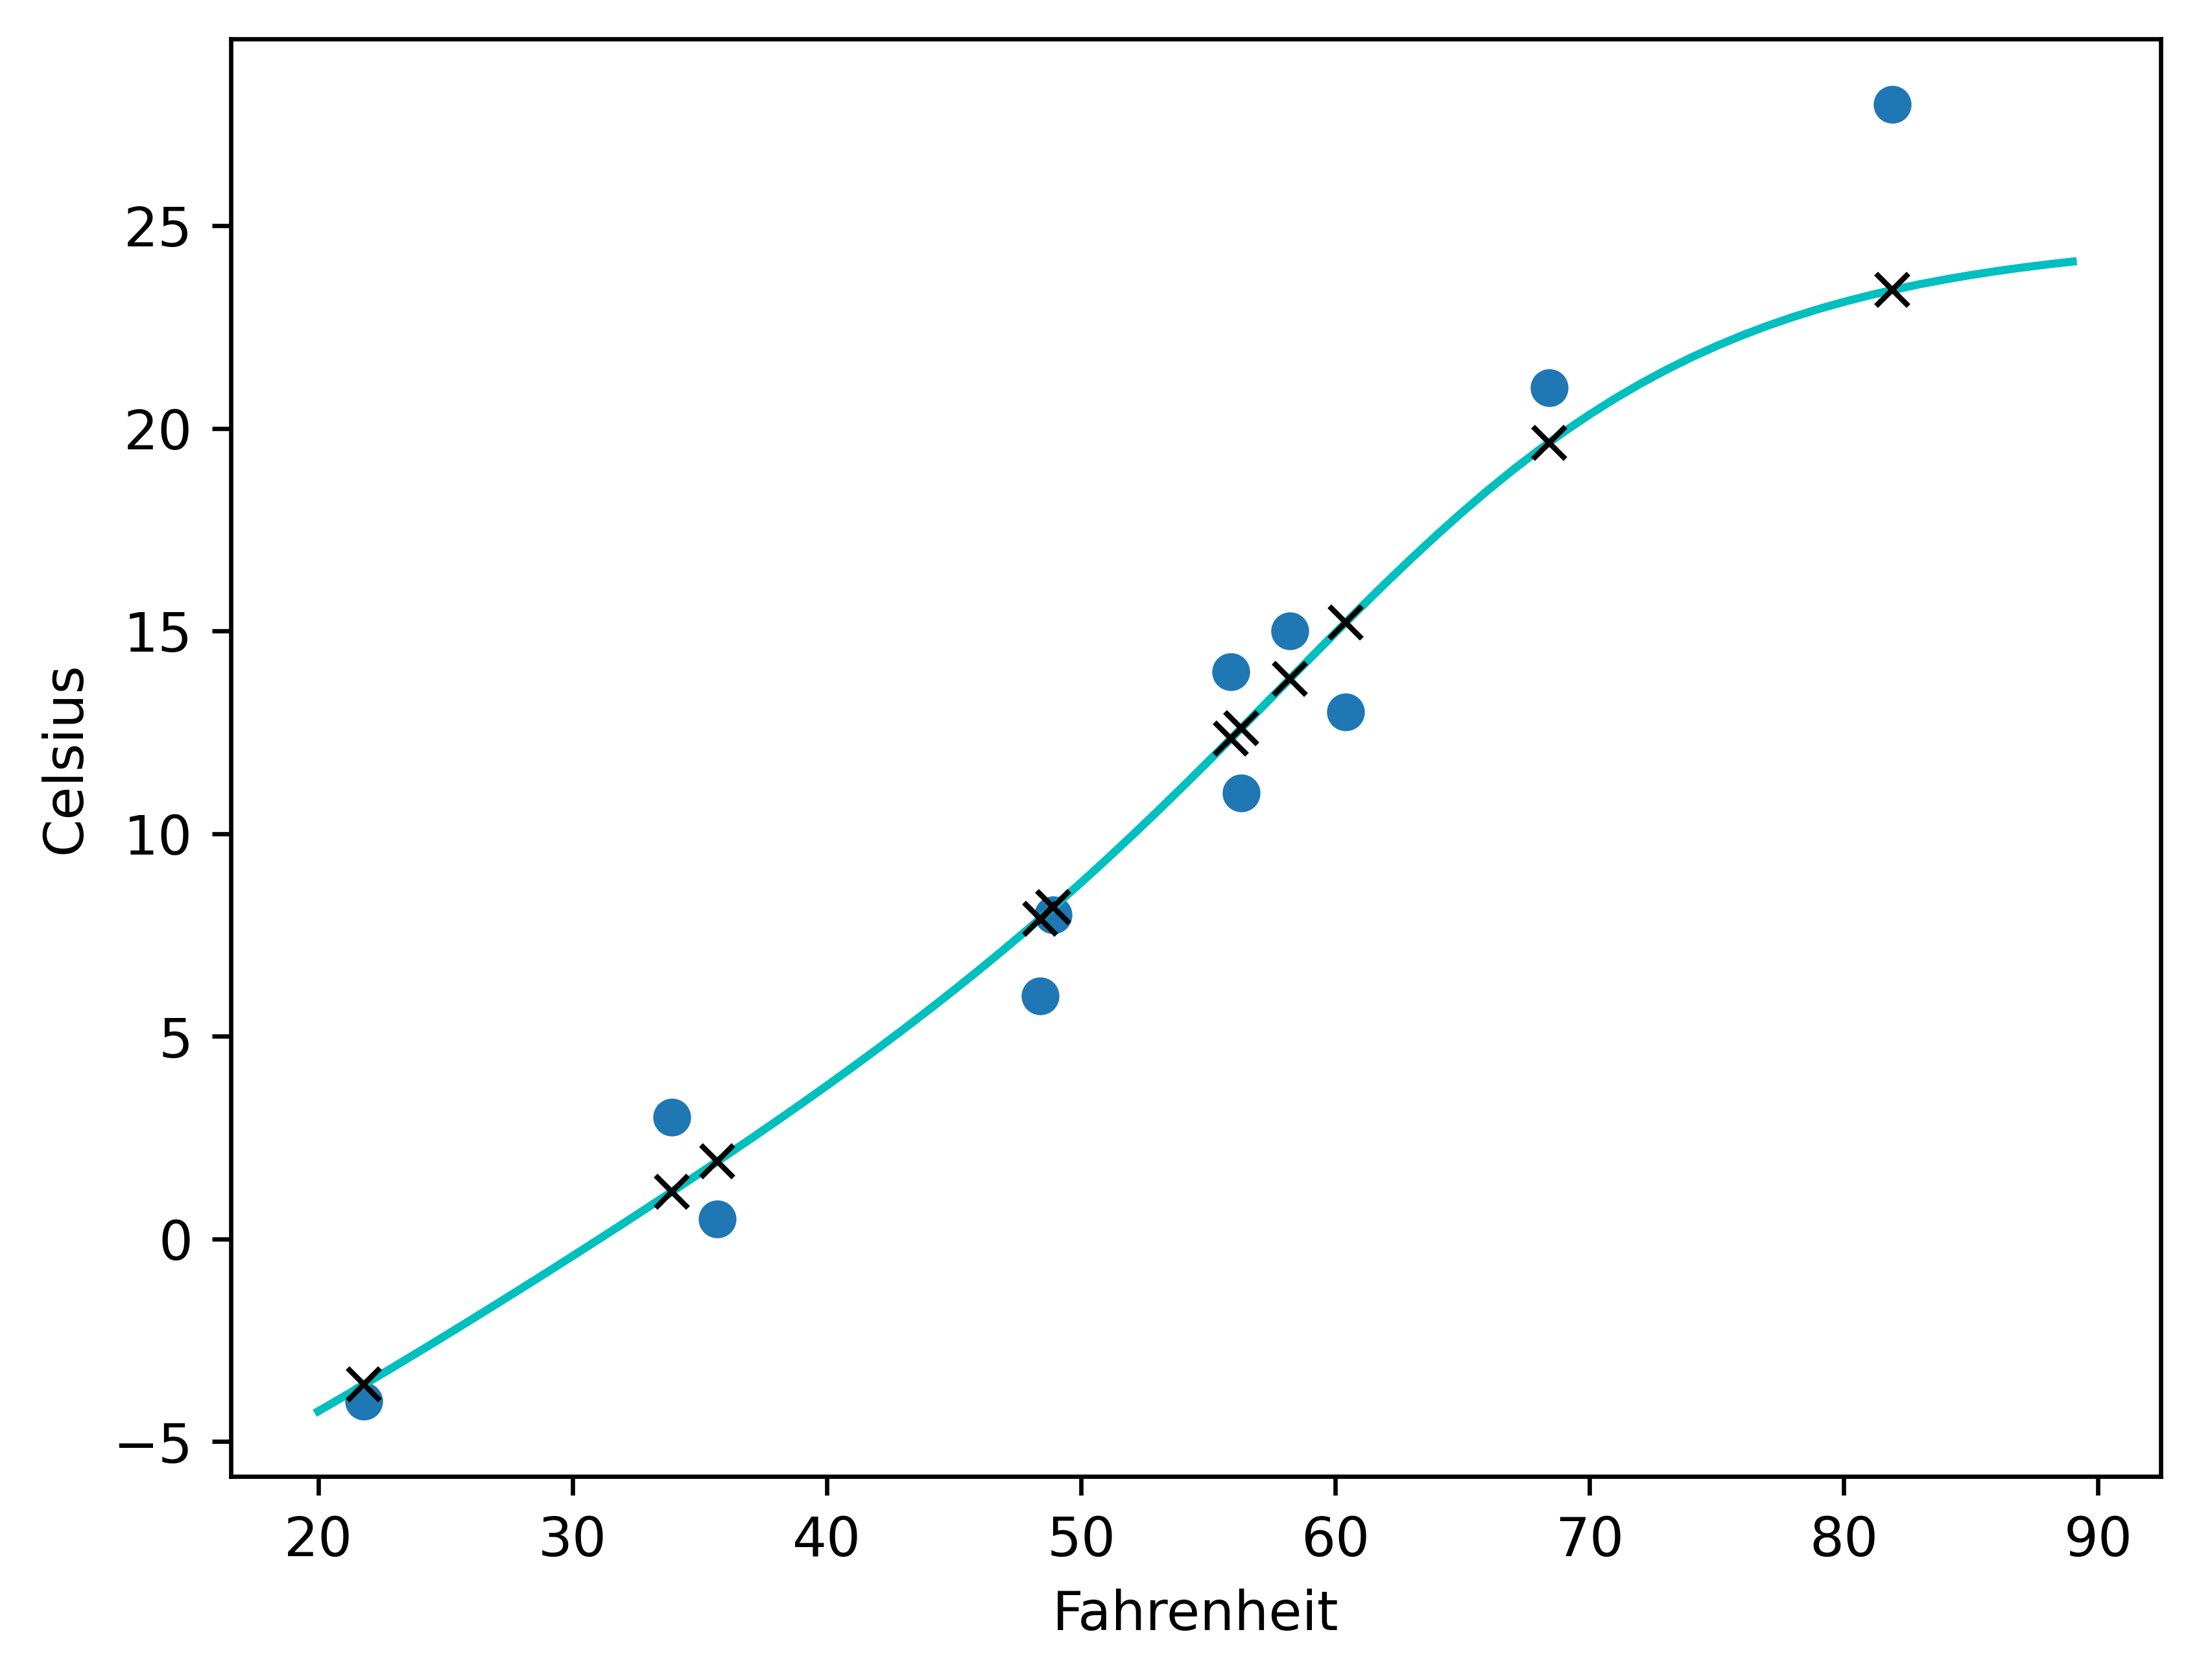

In [25]:
from matplotlib import pyplot as plt

t_range = torch.arange(20.0, 90.0).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), "o")
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), "c-")
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), "kx")